# Projet MonteCarlo 
## Application des méthodes MonteCarlo sur le jeu de Puissance 4

**Auteurs:** Jihed BHAR - Yassine BEN ABDALLAH - Nadia BEN YOUSSEF


----

### Importation des librairies

In [ ]:
import numpy as np
import math
import random
from copy import deepcopy
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

### Implémentation de la classe Connect4Game

Cette classe définit les règles du jeu et gère l'état du plateau

In [2]:
class Connect4Game:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.current_player = 1
        self.game_over = False
        self.winner = None

    def get_valid_moves(self):
        return [col for col in range(self.columns) if self.board[0][col] == 0]

    def make_move(self, column):
        if column not in self.get_valid_moves():
            return False
        for row in range(self.rows-1, -1, -1):
            if self.board[row][column] == 0:
                self.board[row][column] = self.current_player
                break
        if self.check_win(self.current_player):
            self.game_over = True
            self.winner = self.current_player
        elif not self.get_valid_moves():
            self.game_over = True
        self.current_player = 3 - self.current_player
        return True

    def check_win(self, player):
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if all(self.board[row][col+i] == player for i in range(4)):
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns):
                if all(self.board[row+i][col] == player for i in range(4)):
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if all(self.board[row+i][col+i] == player for i in range(4)):
                    return True
                if all(self.board[row+3-i][col+i] == player for i in range(4)):
                    return True
        return False

    def print_board(self):
        print('-' * (2 * self.columns + 1))
        for row in range(self.rows):
            print('|', end='')
            for col in range(self.columns):
                print(' ' if self.board[row][col] == 0 else 'R' if self.board[row][col] == 1 else 'Y', end='|')
            print()
        print('-' * (2 * self.columns + 1))
        print(' ', end='')
        for col in range(self.columns):
            print(f'{col}', end=' ')
        print()

### Implémentation de la classe Node

In [5]:
class Node:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = deepcopy(game_state)
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0
        self.sum_of_squares = 0
        self.untried_moves = game_state.get_valid_moves()

    def select_child(self):
        c = 1.41
        best_score = -float('inf')
        best_child = None
        for child in self.children:
            exploitation = child.wins / child.visits if child.visits > 0 else 0
            exploration = math.sqrt(2 * math.log(self.visits) / child.visits) if child.visits > 0 else float('inf')
            score = exploitation + c * exploration
            if score > best_score:
                best_score = score
                best_child = child
        return best_child

    def add_child(self, move, game_state):
        child = Node(game_state, self, move)
        self.untried_moves.remove(move)
        self.children.append(child)
        return child

    def update(self, result):
        self.visits += 1
        self.wins += result
        self.sum_of_squares += result * result

### Implémentation de l'algorithme Monte Carlo Tree Search (MCTS) standard

In [6]:
class MCTS:
    def __init__(self, iterations=1000):  # Réduit à 1000 pour test
        self.iterations = iterations

    def get_best_move(self, game_state):
        root = Node(game_state)
        for _ in range(self.iterations):
            node = root
            state = deepcopy(game_state)
            while node.untried_moves == [] and node.children != []:
                node = node.select_child()
                state.make_move(node.move)
            if node.untried_moves:
                move = random.choice(node.untried_moves)
                state.make_move(move)
                node = node.add_child(move, state)
            while not state.game_over and state.get_valid_moves():
                state.make_move(random.choice(state.get_valid_moves()))  # Simulation aléatoire
            while node:
                result = 0.5 if state.winner is None else 1.0 if state.winner == game_state.current_player else 0.0
                node.update(result)
                node = node.parent
        best_child = max(root.children, key=lambda c: c.visits, default=None)
        return best_child.move if best_child else random.choice(game_state.get_valid_moves())

### Implémentation de la classe RAVENode

In [ ]:
class RAVENode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = deepcopy(game_state)
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0
        self.amaf_wins = {}  # Dictionnaire pour stocker les victoires AMAF par action
        self.amaf_visits = {}  # Dictionnaire pour stocker les visites AMAF par action
        self.untried_moves = game_state.get_valid_moves()
        
        for move in range(game_state.columns):
            self.amaf_wins[move] = 0
            self.amaf_visits[move] = 0

    def select_rave_child(self):
        k = 500 
        best_score = -float('inf')
        best_child = None
        
        for child in self.children:
            if child.visits == 0:
                return child
                
            # Calcul de β (diminue avec le nombre de visites)
            beta = math.sqrt(k / (3 * child.visits + k))
            
            # Score MCTS standard
            mcts_score = child.wins / child.visits
            
            # Score AMAF
            amaf_score = 0
            if child.move in self.amaf_visits and self.amaf_visits[child.move] > 0:
                amaf_score = self.amaf_wins[child.move] / self.amaf_visits[child.move]
            
            # Combinaison des scores avec le coefficient β
            score = (1 - beta) * mcts_score + beta * amaf_score

            if child.visits > 0:
                exploration = 0.2 * math.sqrt(math.log(self.visits) / child.visits)
                score += exploration
            
            if score > best_score:
                best_score = score
                best_child = child
                
        return best_child

    def add_child(self, move, game_state):
        child = RAVENode(game_state, self, move)
        self.untried_moves.remove(move)
        self.children.append(child)
        return child

    def update(self, result):
        self.visits += 1
        self.wins += result

    def update_amaf(self, move, result):
        if move not in self.amaf_visits or move not in self.amaf_wins:
            self.amaf_wins[move] = 0
            self.amaf_visits[move] = 0
        self.amaf_visits[move] += 1
        self.amaf_wins[move] += result

### Implémentation de l'algorithme RAVE

In [13]:
class RAVE:
    def __init__(self, iterations=2000):
        self.iterations = iterations

    def get_best_move(self, game_state):
        root = RAVENode(game_state)
        
        for _ in range(self.iterations):
            node = root
            state = deepcopy(game_state)
            
            # Phase de sélection - utilise la sélection RAVE
            while node.untried_moves == [] and node.children != []:
                node = node.select_rave_child()
                state.make_move(node.move)
            
            # Phase d'expansion
            if node.untried_moves:
                move = random.choice(node.untried_moves)
                state.make_move(move)
                node = node.add_child(move, state)
            
            # Phase de simulation avec suivi des coups joués
            played_moves = []
            while not state.game_over and state.get_valid_moves():
                # Simulation semi-aléatoire: vérifie d'abord s'il y a une victoire immédiate
                win_move = self._check_winning_move(state)
                if win_move is not None:
                    move = win_move
                else:
                    move = random.choice(state.get_valid_moves())
                
                played_moves.append((state.current_player, move))
                state.make_move(move)
            
            if state.winner is None:
                result = 0.5  # Match nul
            else:
                result = 1.0 if state.winner == game_state.current_player else 0.0
                
            # Phase de rétropropagation avec mise à jour AMAF
            current = node
            while current:
                current.update(result)
                
                for player, move in played_moves:
                    # On ne considère que les coups du même joueur pour AMAF
                    if player == current.game_state.current_player:
                        current.update_amaf(move, result)
                
                current = current.parent
        
        # Sélection du meilleur coup selon le nombre de visites
        best_child = max(root.children, key=lambda c: c.visits, default=None)
        return best_child.move if best_child else random.choice(game_state.get_valid_moves())
    
    def _check_winning_move(self, state):
        for move in state.get_valid_moves():
            test_state = deepcopy(state)
            test_state.make_move(move)
            # Vérifier si le coup précédent était gagnant
            if test_state.winner == state.current_player:
                return move
        return None

### Fonction de simulation pour comparer MCTS et RAVE

In [18]:
def run_simulation_mcts_vs_rave(num_games=100):
    wins_mcts = 0
    wins_rave = 0
    draws = 0
    wins_starting = 0
    wins_second = 0
    
    # Mesure du temps d'exécution
    mcts_total_time = 0
    rave_total_time = 0

    print(f"Simulation de {num_games} parties entre MCTS et RAVE...")
    mcts = MCTS(iterations=2000)
    rave = RAVE(iterations=2000)

    for game_num in range(num_games):
        game = Connect4Game()
        AI_red = rave if game_num % 2 == 1 else mcts
        AI_yellow = mcts if game_num % 2 == 1 else rave
        red_is_mcts = game_num % 2 == 0

        print(f"\nPartie {game_num + 1}/{num_games}")
        print(f"Rouge (commence): {'MCTS' if red_is_mcts else 'RAVE'}")
        print(f"Jaune (second): {'RAVE' if red_is_mcts else 'MCTS'}")

        last_move = None
        while not game.game_over:
            if game.current_player == 1:  # Rouge
                start_time = time.time()
                ai_move = AI_red.get_best_move(game)
                end_time = time.time()
                if red_is_mcts:
                    mcts_total_time += (end_time - start_time)
                else:
                    rave_total_time += (end_time - start_time)
            else:  # Jaune
                start_time = time.time()
                ai_move = AI_yellow.get_best_move(game)
                end_time = time.time()
                if red_is_mcts:
                    rave_total_time += (end_time - start_time)
                else:
                    mcts_total_time += (end_time - start_time)
                
            game.make_move(ai_move)
            last_move = ai_move

        game.print_board()
        if game.winner is None:
            draws += 1
            print("Résultat: Match nul")
        elif game.winner == 1:
            wins_starting += 1
            if red_is_mcts:
                wins_mcts += 1
                print(f"Résultat: Rouge gagne (MCTS) - Dernier coup: {last_move}")
            else:
                wins_rave += 1
                print(f"Résultat: Rouge gagne (RAVE) - Dernier coup: {last_move}")
        else:
            wins_second += 1
            if red_is_mcts:
                wins_rave += 1
                print(f"Résultat: Jaune gagne (RAVE) - Dernier coup: {last_move}")
            else:
                wins_mcts += 1
                print(f"Résultat: Jaune gagne (MCTS) - Dernier coup: {last_move}")

    total_moves = 42 * num_games 
    avg_mcts_time = mcts_total_time / (total_moves / 2) if total_moves > 0 else 0
    avg_rave_time = rave_total_time / (total_moves / 2) if total_moves > 0 else 0
    
    return {
        'wins_mcts': wins_mcts, 
        'wins_rave': wins_rave,
        'draws': draws,
        'wins_starting': wins_starting,
        'wins_second': wins_second,
        'mcts_total_time': mcts_total_time,
        'rave_total_time': rave_total_time,
        'avg_mcts_time': avg_mcts_time,
        'avg_rave_time': avg_rave_time,
        'num_games': num_games
    }


In [24]:
if __name__ == "__main__":
    results = run_simulation_mcts_vs_rave(100)

Simulation de 100 parties entre MCTS et RAVE...

Partie 1/100
Rouge (commence): MCTS
Jaune (second): RAVE
---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | |Y|R| | | |
| | |Y|R| | | |
| | |Y|R| | | |
---------------
 0 1 2 3 4 5 6 
Résultat: Rouge gagne (MCTS) - Dernier coup: 3

Partie 2/100
Rouge (commence): RAVE
Jaune (second): MCTS
---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | | |R|Y| | |
| | | |R|Y| | |
| | | |R|Y| | |
---------------
 0 1 2 3 4 5 6 
Résultat: Rouge gagne (RAVE) - Dernier coup: 3

Partie 3/100
Rouge (commence): MCTS
Jaune (second): RAVE
---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | | |R|Y| | |
| | | |R|Y| | |
| | | |R|Y| | |
---------------
 0 1 2 3 4 5 6 
Résultat: Rouge gagne (MCTS) - Dernier coup: 3

Partie 4/100
Rouge (commence): RAVE
Jaune (second): MCTS
---------------
| | | | | | | |
| | | | | | | |
|R| | | | | | |
|R| |Y|Y| | | |
|R| |Y|R| | | |
|R| |Y|R|Y| | |
---------------
 0 1 2 3 4 5 6 
Rés

In [25]:
def display_results(results):
    num_games = results['num_games']
    
    print("\n--- Statistiques après {} parties ---".format(num_games))
    print(f"MCTS: {results['wins_mcts']} victoires ({results['wins_mcts']/num_games*100:.1f}%)")
    print(f"RAVE: {results['wins_rave']} victoires ({results['wins_rave']/num_games*100:.1f}%)")
    print(f"Matchs nuls: {results['draws']} ({results['draws']/num_games*100:.1f}%)")
    print(f"Rouge (premier): {results['wins_starting']} victoires ({results['wins_starting']/num_games*100:.1f}%)")
    print(f"Jaune (second): {results['wins_second']} victoires ({results['wins_second']/num_games*100:.1f}%)")
    
    print("\n--- Temps d'exécution ---")
    print(f"MCTS: Temps total = {results['mcts_total_time']:.2f}s, Temps moyen par coup = {results['avg_mcts_time']*1000:.2f}ms")
    print(f"RAVE: Temps total = {results['rave_total_time']:.2f}s, Temps moyen par coup = {results['avg_rave_time']*1000:.2f}ms")
    print(f"Rapport MCTS/RAVE: {results['mcts_total_time']/results['rave_total_time'] if results['rave_total_time'] > 0 else 'N/A'}")

In [26]:
display_results(results)


--- Statistiques après 100 parties ---
MCTS: 73 victoires (73.0%)
RAVE: 27 victoires (27.0%)
Matchs nuls: 0 (0.0%)
Rouge (premier): 77 victoires (77.0%)
Jaune (second): 23 victoires (23.0%)

--- Temps d'exécution ---
MCTS: Temps total = 530.05s, Temps moyen par coup = 252.41ms
RAVE: Temps total = 653.89s, Temps moyen par coup = 311.38ms
Rapport MCTS/RAVE: 0.8106127385829057


In [ ]:
# Fonction pour exécuter plusieurs simulations et collecter les données
def run_multiple_simulations(num_simulations=5, games_per_simulation=20):
    all_results = []
    
    # Variables pour stocker les temps d'exécution moyens
    total_mcts_time = 0
    total_rave_time = 0
    
    for sim in range(num_simulations):
        print(f"Simulation {sim+1}/{num_simulations}")
        
        # Variables pour stocker les résultats
        wins_mcts = 0
        wins_rave = 0
        draws = 0
        wins_starting = 0
        wins_second = 0
        
        # Utiliser les versions améliorées avec 2000 itérations
        mcts = MCTS(iterations=2000)
        rave = RAVE(iterations=2000)
        
        # Variables pour mesurer le temps
        mcts_sim_time = 0
        rave_sim_time = 0
        
        for game_num in range(games_per_simulation):
            game = Connect4Game()
            AI_red = rave if game_num % 2 == 1 else mcts
            AI_yellow = mcts if game_num % 2 == 1 else rave
            red_is_mcts = game_num % 2 == 0
            
            # Joue la partie sans affichage, mais avec mesure du temps
            while not game.game_over:
                if game.current_player == 1:  # Rouge
                    start_time = time.time()
                    ai_move = AI_red.get_best_move(game)
                    end_time = time.time()
                    if red_is_mcts:
                        mcts_sim_time += (end_time - start_time)
                    else:
                        rave_sim_time += (end_time - start_time)
                else:  # Jaune
                    start_time = time.time()
                    ai_move = AI_yellow.get_best_move(game)
                    end_time = time.time()
                    if red_is_mcts:
                        rave_sim_time += (end_time - start_time)
                    else:
                        mcts_sim_time += (end_time - start_time)
                
                game.make_move(ai_move)
            
            # Comptabilise les résultats
            if game.winner is None:
                draws += 1
            elif game.winner == 1:
                wins_starting += 1
                if red_is_mcts:
                    wins_mcts += 1
                else:
                    wins_rave += 1
            else:
                wins_second += 1
                if red_is_mcts:
                    wins_rave += 1
                else:
                    wins_mcts += 1
        
        # Ajout du temps d'exécution au total
        total_mcts_time += mcts_sim_time
        total_rave_time += rave_sim_time
        
        # Stocke les résultats de cette simulation
        all_results.append({
            'sim_id': sim+1,
            'mcts_wins': wins_mcts,
            'rave_wins': wins_rave, 
            'draws': draws,
            'first_player_wins': wins_starting,
            'second_player_wins': wins_second,
            'mcts_win_rate': wins_mcts / games_per_simulation * 100,
            'rave_win_rate': wins_rave / games_per_simulation * 100,
            'draw_rate': draws / games_per_simulation * 100,
            'first_player_win_rate': wins_starting / games_per_simulation * 100,
            'second_player_win_rate': wins_second / games_per_simulation * 100,
            'mcts_time': mcts_sim_time,
            'rave_time': rave_sim_time
        })
    
    # Convertit les résultats en DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Afficher les temps d'exécution moyens
    avg_mcts_time = total_mcts_time / num_simulations
    avg_rave_time = total_rave_time / num_simulations
    print(f"\nTemps d'exécution moyen par simulation:")
    print(f"MCTS: {avg_mcts_time:.2f}s")
    print(f"RAVE: {avg_rave_time:.2f}s")
    print(f"Rapport MCTS/RAVE: {avg_mcts_time/avg_rave_time:.2f}x")
    
    return results_df


In [28]:
results = run_multiple_simulations(num_simulations=5, games_per_simulation=20)
print(results)

Simulation 1/5
Simulation 2/5
Simulation 3/5
Simulation 4/5
Simulation 5/5

Temps d'exécution moyen par simulation:
MCTS: 113.35s
RAVE: 140.26s
Rapport MCTS/RAVE: 0.81x
   sim_id  mcts_wins  rave_wins  draws  first_player_wins  second_player_wins  \
0       1         17          3      0                 13                   7   
1       2         19          1      0                 11                   9   
2       3         15          5      0                 15                   5   
3       4         16          4      0                 14                   6   
4       5         14          6      0                 16                   4   

   mcts_win_rate  rave_win_rate  draw_rate  first_player_win_rate  \
0           85.0           15.0        0.0                   65.0   
1           95.0            5.0        0.0                   55.0   
2           75.0           25.0        0.0                   75.0   
3           80.0           20.0        0.0                   70.0   

In [34]:

# Calcul des moyennes et écarts-types
avg_results = {
    'MCTS Win Rate': results['mcts_win_rate'].mean(),
    'RAVE Win Rate': results['rave_win_rate'].mean(),
    'Draw Rate': results['draw_rate'].mean(),
    'First Player Win Rate': results['first_player_win_rate'].mean(),
    'Second Player Win Rate': results['second_player_win_rate'].mean()
}

std_results = {
    'MCTS Win Rate': results['mcts_win_rate'].std(),
    'RAVE Win Rate': results['rave_win_rate'].std(),
    'Draw Rate': results['draw_rate'].std(),
    'First Player Win Rate': results['first_player_win_rate'].std(),
    'Second Player Win Rate': results['second_player_win_rate'].std()
}

# Affichage des statistiques globales
print("\n===== Statistiques moyennes sur toutes les simulations =====")
for key, value in avg_results.items():
    print(f"{key}: {value:.2f}% ± {std_results[key]:.2f}%")



===== Statistiques moyennes sur toutes les simulations =====
MCTS Win Rate: 81.00% ± 9.62%
RAVE Win Rate: 19.00% ± 9.62%
Draw Rate: 0.00% ± 0.00%
First Player Win Rate: 69.00% ± 9.62%
Second Player Win Rate: 31.00% ± 9.62%


In [30]:
# Graphique 1: Comparaison MCTS vs RAVE
algorithms = ['MCTS', 'RAVE', 'Draw']
win_rates = [avg_results['MCTS Win Rate'], avg_results['RAVE Win Rate'], avg_results['Draw Rate']]
error_bars = [std_results['MCTS Win Rate'], std_results['RAVE Win Rate'], std_results['Draw Rate']]
colors = ['royalblue', 'forestgreen', 'gray']

ax1.bar(algorithms, win_rates, yerr=error_bars, color=colors, alpha=0.7)
ax1.set_title('Taux de victoire par algorithme')
ax1.set_ylabel('Pourcentage de victoires (%)')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(win_rates):
    ax1.text(i, value + error_bars[i] + 2, f'{value:.1f}%', ha='center')

In [31]:
# Graphique 2: Avantage du premier joueur
players = ['Premier joueur', 'Second joueur', 'Match nul']
player_rates = [avg_results['First Player Win Rate'], avg_results['Second Player Win Rate'], avg_results['Draw Rate']]
player_errors = [std_results['First Player Win Rate'], std_results['Second Player Win Rate'], std_results['Draw Rate']]
player_colors = ['crimson', 'darkorange', 'gray']

ax2.bar(players, player_rates, yerr=player_errors, color=player_colors, alpha=0.7)
ax2.set_title('Avantage du premier joueur')
ax2.set_ylabel('Pourcentage de victoires (%)')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(player_rates):
    ax2.text(i, value + player_errors[i] + 2, f'{value:.1f}%', ha='center')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

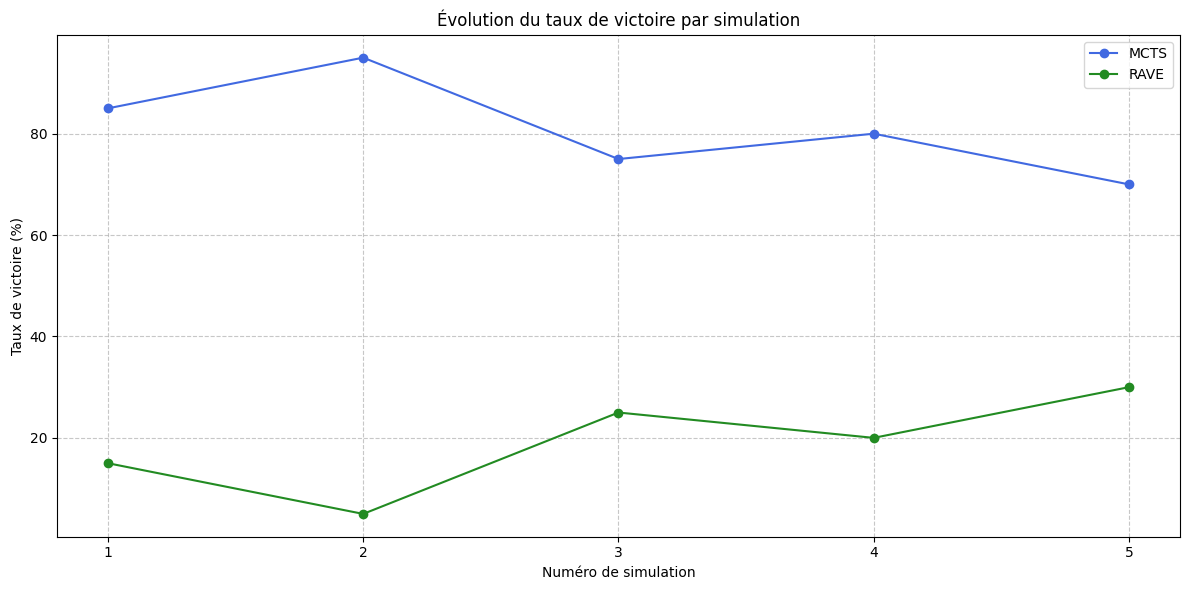

In [32]:
# Évolution des performances sur les simulations
plt.figure(figsize=(12, 6))
plt.plot(results['sim_id'], results['mcts_win_rate'], 'o-', color='royalblue', label='MCTS')
plt.plot(results['sim_id'], results['rave_win_rate'], 'o-', color='forestgreen', label='RAVE')
plt.title('Évolution du taux de victoire par simulation')
plt.xlabel('Numéro de simulation')
plt.ylabel('Taux de victoire (%)')
plt.xticks(results['sim_id'])
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


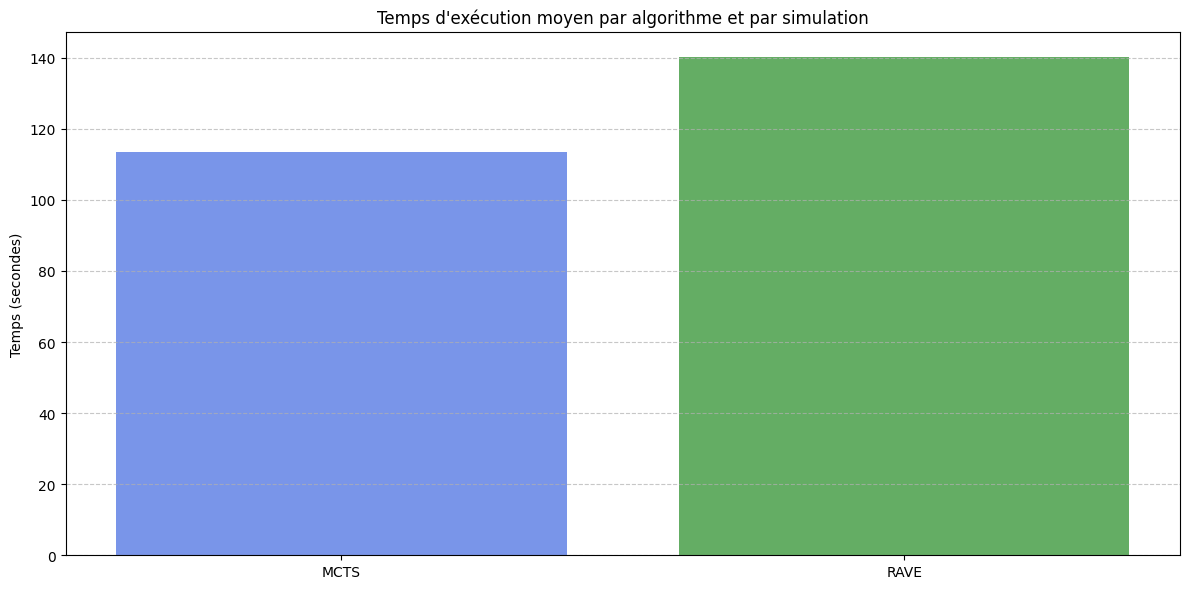

In [33]:
plt.figure(figsize=(12, 6))
plt.bar(['MCTS', 'RAVE'], [results['mcts_time'].mean(), results['rave_time'].mean()], 
        color=['royalblue', 'forestgreen'], alpha=0.7)
plt.title('Temps d\'exécution moyen par algorithme et par simulation')
plt.ylabel('Temps (secondes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

-----

### Implémentation de la classe RAVENode avec k=100

In [ ]:
class RAVENode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = deepcopy(game_state)
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0
        self.amaf_wins = {}  # Dictionnaire pour stocker les victoires AMAF par action
        self.amaf_visits = {}  # Dictionnaire pour stocker les visites AMAF par action
        self.untried_moves = game_state.get_valid_moves()
        
        for move in range(game_state.columns):
            self.amaf_wins[move] = 0
            self.amaf_visits[move] = 0

    def select_rave_child(self):
        k = 100 
        best_score = -float('inf')
        best_child = None
        
        for child in self.children:
            if child.visits == 0:
                return child
                
            # Calcul de β (diminue avec le nombre de visites)
            beta = math.sqrt(k / (3 * child.visits + k))
            
            # Score MCTS standard
            mcts_score = child.wins / child.visits
            
            # Score AMAF
            amaf_score = 0
            if child.move in self.amaf_visits and self.amaf_visits[child.move] > 0:
                amaf_score = self.amaf_wins[child.move] / self.amaf_visits[child.move]
            
            # Combinaison des scores avec le coefficient β
            score = (1 - beta) * mcts_score + beta * amaf_score

            if child.visits > 0:
                exploration = 0.2 * math.sqrt(math.log(self.visits) / child.visits)
                score += exploration
            
            if score > best_score:
                best_score = score
                best_child = child
                
        return best_child

    def add_child(self, move, game_state):
        child = RAVENode(game_state, self, move)
        self.untried_moves.remove(move)
        self.children.append(child)
        return child

    def update(self, result):
        self.visits += 1
        self.wins += result

    def update_amaf(self, move, result):
        if move not in self.amaf_visits or move not in self.amaf_wins:
            self.amaf_wins[move] = 0
            self.amaf_visits[move] = 0
        self.amaf_visits[move] += 1
        self.amaf_wins[move] += result

In [ ]:
if __name__ == "__main__":
    results = run_simulation_mcts_vs_rave(100)

Simulation de 100 parties entre MCTS et RAVE...

Partie 1/100
Rouge (commence): MCTS
Jaune (second): RAVE
---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | |Y|R| | | |
| | |Y|R| | | |
| | |Y|R| | | |
---------------
 0 1 2 3 4 5 6 
Résultat: Rouge gagne (MCTS) - Dernier coup: 3

Partie 2/100
Rouge (commence): RAVE
Jaune (second): MCTS
---------------
| | | | | | | |
| | | |Y| | | |
| | | |Y| |R| |
| | |Y|Y|Y|R| |
| | |R|Y|R|R| |
| |Y|R|R|R|Y| |
---------------
 0 1 2 3 4 5 6 
Résultat: Jaune gagne (MCTS) - Dernier coup: 3

Partie 3/100
Rouge (commence): MCTS
Jaune (second): RAVE
---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | |Y|R| | | |
| | |Y|R| | | |
| | |Y|R| | | |
---------------
 0 1 2 3 4 5 6 
Résultat: Rouge gagne (MCTS) - Dernier coup: 3

Partie 4/100
Rouge (commence): RAVE
Jaune (second): MCTS
---------------
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |R| | | |
|R|R|R|R|Y| | |
---------------
 0 1 2 3 4 5 6 
Rés

In [ ]:
display_results(results)


--- Statistiques après 100 parties ---
MCTS: 81 victoires (81.0%)
RAVE: 19 victoires (19.0%)
Matchs nuls: 0 (0.0%)
Rouge (premier): 69 victoires (69.0%)
Jaune (second): 31 victoires (31.0%)

--- Temps d'exécution ---
MCTS: Temps total = 579.38s, Temps moyen par coup = 275.90ms
RAVE: Temps total = 866.07s, Temps moyen par coup = 412.41ms
Rapport MCTS/RAVE: 0.6689844858426577
